# Text analysis with spaCy and textacy

## Install required packages and models

In [1]:
!pip install spacy
!pip install textacy
!pip install pandas

# Install large English web document model
!python -m spacy download en_core_web_lg

## for python2.7 only
# pip install "msgpack-numpy<0.4.4.0"

fitz 0.0.1.dev2 requires configobj, which is not installed.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
fitz 0.0.1.dev2 requires configobj, which is not installed.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


fitz 0.0.1.dev2 requires configobj, which is not installed.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
fitz 0.0.1.dev2 requires configobj, which is not installed.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


## What is spaCy?
https://spacy.io

spaCy is a library for advanced Natural Language Processing, written in Python and Cython. spaCy utilizes convolution network models for English, German, Spanish, Portuguese, French, Italian, Dutch and multi-language NER, as well as tokenization for various other languages.

spaCy is designed for large scale text extraction, using Cython to provide increased processing speed. spaCy also supports deep learning workflows that allow connecting statistical models trained by popular machine learning libraries like TensorFlow, Keras, Scikit-learn or PyTorch.

In [2]:
import spacy
from spacy import displacy # visualization tools for spaCy

## Model: 'en_core_web_lg'

English multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl. Assigns word vectors, context-specific token vectors, POS tags, syntactic dependency parse and named entities.

685k keys, 685k unique vectors (300 dimensions)

In [3]:
nlp = spacy.load('en_core_web_lg')

## Tokenization

spaCy automatically tokenizes text and provides several context relevant properties for each token.

Let's look at the following sentence:

**In downtown Evanston, Rhonda Smith bought 1 iPhone at 8 a.m. on October 5th because they were 30% off at BestBuy.**

In [4]:
# process document with spaCy nlp model
doc = nlp(u'In downtown Evanston, Rhonda Smith bought 1 iPhone at 8 a.m. on October 5th because they were 30% off at BestBuy.')

# get tokenized representation of sentence
tokenized = [token for token in doc]
print(tokenized)

[In, downtown, Evanston, ,, Rhonda, Smith, bought, 1, iPhone, at, 8, a.m., on, October, 5th, because, they, were, 30, %, off, at, BestBuy, .]


## Named entity recognition

In [5]:
displacy.render(doc, style='ent', jupyter=True)

In [6]:
# named entities can be use for disambiguation

doc = nlp(u"Tim Cook, CEO of Apple, has many apple trees on his property.")
displacy.render(doc, style='ent', jupyter=True)

## Token properties

In [7]:
# print properties of each token in sentence

import pandas as pd
from IPython.display import display, HTML

df = pd.DataFrame(columns='TEXT LEMMA POS TAG DEP SHAPE ALPHA ENT'.split())

for token in doc:
    tokendict = {'TEXT':token.text,
                 'LEMMA':token.lemma_,
                 'POS':token.pos_,
                 'TAG':token.tag_,
                 'DEP':token.dep_,
                 'SHAPE':token.shape_,
                 'ALPHA':token.is_alpha,
                 'ENT':token.ent_type_}
    df = df.append(tokendict, ignore_index=True)

display(HTML(df.to_html(index=False)))


TEXT,LEMMA,POS,TAG,DEP,SHAPE,ALPHA,ENT
Tim,Tim,PROPN,NNP,compound,Xxx,True,PERSON
Cook,Cook,PROPN,NNP,nsubj,Xxxx,True,PERSON
",",",",PUNCT,",",punct,",",False,
CEO,CEO,PROPN,NNP,appos,XXX,True,
of,of,ADP,IN,prep,xx,True,
Apple,Apple,PROPN,NNP,pobj,Xxxxx,True,ORG
",",",",PUNCT,",",punct,",",False,
has,have,AUX,VBZ,ROOT,xxx,True,
many,many,ADJ,JJ,amod,xxxx,True,
apple,apple,NOUN,NN,compound,xxxx,True,


## Syntactic dependency relationships

Syntactic dependencies are the grammatical relationships between words. spaCy can be used to extract this dependency information from sentences in a text. 

In [8]:
# visualization of syntactic dependency 
displacy.render(doc, style='dep', jupyter=True)

In [9]:
# syntactic dependency relationships in practice
# currency values and the nouns they refer to


TEXTS = [
    """Google just made another giant move in its Silicon Valley land grab.

The internet company spent $1 billion on a large office park near its headquarters in Mountain View, California, according to the Mercury News, and has now spent at least $2.8 billion on properties in Mountain View, Sunnyvale and San Jose over the last two years.
In this case, Google is purchasing property that it's already been leasing. The company is the main tenant of the 12 buildings that comprise the 51.8-acre Shoreline Technology Park.

Google declined to comment on its purchase.

Earlier this month, Google agreed to pay an additional $110 million for 10.5 acres for a new campus in downtown San Jose, with the possibility of buying about 11 more acres. The city will vote on the plans in early December.
It's also been a big year for Google property purchases outside of Silicon Valley.

In the first quarter, the company spent $2.4 billion to buy New York City's Chelsea Market. Chief Financial Officer Ruth Porat said that the company favors "owning rather than leasing real estate when we see good opportunities."

As for leases, Google just signed on for a massive new space in downtown San Francisco."""
]

class stop_loop(Exception): pass

def qualifier_value(money_txt):
    money_doc = nlp(str(money_txt))
    pos_list = [token.pos_ for token in money_doc]
    money_list = [token.text for token in money_doc]
    money_start = min(loc for loc, pos in enumerate(pos_list) if (pos == 'SYM' or pos == 'NUM'))
    qualifier = ' '.join(money_list[:money_start])
    value = ' '.join(money_list[money_start:])
    return qualifier, value
    

def extract_currency_relations(doc):
    # merge entities and noun chunks into one token
    spans = list(doc.ents) + list(doc.noun_chunks)
    for span in spans:
        span.merge()

    relations = []
    for money in filter(lambda w: w.ent_type_ == 'MONEY', doc):
        try:
            # syntactic relationship 1
            advcl = [w for w in money.head.children if w.dep_ == 'advcl']
            if advcl:
                for child in advcl[0].children:
                    if child.dep_ == 'dobj':
                        parse_type = 1
                        qual, val = qualifier_value(money.text)
                        relations.append((qual, val, child, parse_type))
                        raise stop_loop()
                        
            # syntactic relationship 2
            cprep = [w for w in money.children if w.dep_ == 'prep']
            if cprep:
                for child in cprep[0].children:
                    if child.dep_ == 'pobj':
                        parse_type = 2
                        qual, val = qualifier_value(money.text)
                        relations.append((qual, val, child, parse_type))
                        raise stop_loop()
            
            # syntactic relationship 3
            hprep = [w for w in money.head.children if w.dep_ == 'prep']
            if hprep:
                for child in hprep[0].children:
                    if child.dep_ == 'pobj':
                        parse_type = 3
                        qual, val = qualifier_value(money.text)
                        relations.append((qual, val, child, parse_type))
                        raise stop_loop()
                        
            # syntactic relationship 4
            if money.dep_ in ('attr', 'dobj'):
                subject = [w for w in money.head.lefts if w.dep_ == 'nsubj']
                if subject:
                    parse_type = 4
                    subject = subject[0]
                    qual, val = qualifier_value(money.text)
                    relations.append((qual, val, subject, parse_type))
                    raise stop_loop()
                    
            # syntactic relationship 5
            elif money.dep_ == 'pobj' and money.head.dep_ == 'prep':
                parse_type = 5
                qual, val = qualifier_value(money.text)
                relations.append((qual, val, money.head.head, parse_type))
                raise stop_loop()
                
        except stop_loop:
            pass
                 
    return relations

df = pd.DataFrame(columns='QUALIFIER VALUE ASSET'.split())

for text in TEXTS:
    print(text)
    #doc = nlp(unicode(text, 'utf-8'))
    doc = nlp(str(text))
    relations = extract_currency_relations(doc)
    for r0, r1, r2, r3 in relations:
        relation_dict = {'QUALIFIER':r0, 'VALUE':r1, 'ASSET':r2.text}
        #relation_dict = {'MONETARY_VALUE':r2.text, 'ASSET':r1.text}
        df = df.append(relation_dict, ignore_index=True)
        #print('{:<10}\t{}\t{}'.format(r1.text, r2.ent_type_, r2.text))
    #print('\n')

display(HTML(df.to_html(index=False)))


Google just made another giant move in its Silicon Valley land grab.

The internet company spent $1 billion on a large office park near its headquarters in Mountain View, California, according to the Mercury News, and has now spent at least $2.8 billion on properties in Mountain View, Sunnyvale and San Jose over the last two years.
In this case, Google is purchasing property that it's already been leasing. The company is the main tenant of the 12 buildings that comprise the 51.8-acre Shoreline Technology Park.

Google declined to comment on its purchase.

Earlier this month, Google agreed to pay an additional $110 million for 10.5 acres for a new campus in downtown San Jose, with the possibility of buying about 11 more acres. The city will vote on the plans in early December.
It's also been a big year for Google property purchases outside of Silicon Valley.

In the first quarter, the company spent $2.4 billion to buy New York City's Chelsea Market. Chief Financial Officer Ruth Porat sa

QUALIFIER,VALUE,ASSET
,$ 1 billion,a large office park
at least,$ 2.8 billion,properties
an additional,$ 110 million,10.5 acres
,$ 2.4 billion,New York City's Chelsea Market


In [10]:
# Convert monetary values to integer using regex substitution

import re

int_values = []
for text_value in df['VALUE']:
    if 'million' in text_value:
        money_expr = re.sub('million', '*1000000', text_value.strip())
    elif 'billion' in text_value:
        money_expr = re.sub('billion', '*1000000000', text_value.strip())
    money_expr = re.sub(r'\$', '', money_expr)
    money_int = eval(money_expr)
    int_values.append(int(money_int))
    
df = df.assign(VALUE=int_values)

display(HTML(df.to_html(index=False)))

QUALIFIER,VALUE,ASSET
,1000000000,a large office park
at least,2800000000,properties
an additional,110000000,10.5 acres
,2400000000,New York City's Chelsea Market


## textacy 
https://chartbeat-labs.github.io/textacy/index.html

textacy builds upon spaCy's framework and provides convenient functions for many advanced NLP tools. textacy also performs basic text feature counts and computes several readability measures. 

In [11]:
!pip install nltk 
!pip install textacy

fitz 0.0.1.dev2 requires configobj, which is not installed.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
fitz 0.0.1.dev2 requires configobj, which is not installed.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
# perform topic model of Presidental Inaugural addresses
# download speeches from nltk

import nltk
nltk.download('inaugural')

[nltk_data] Downloading package inaugural to
[nltk_data]     /home/rwn8669/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!


True

In [4]:
# get collect measures from Obama's inaugural address

# import the inaugural addresses
from nltk.corpus import inaugural

names = inaugural.fileids()
name = names[-1]
print(name)

filetext = inaugural.raw(fileids=name)
doc = nlp(filetext)

# print first ten lines as sample
for line in filetext.splitlines()[:10]:print(line)

2009-Obama.txt
My fellow citizens:

I stand here today humbled by the task before us, grateful for the trust you have bestowed, mindful of the sacrifices borne by our ancestors. I thank President Bush for his service to our nation, as well as the generosity and cooperation he has shown throughout this transition.

Forty-four Americans have now taken the presidential oath. The words have been spoken during rising tides of prosperity and the still waters of peace. Yet, every so often the oath is taken amidst gathering clouds and raging storms. At these moments, America has carried on not simply because of the skill or vision of those in high office, but because We the People have remained faithful to the ideals of our forbearers, and true to our founding documents.

So it has been. So it must be with this generation of Americans.

That we are in the midst of crisis is now well understood. Our nation is at war, against a far-reaching network of violence and hatred. Our economy is badly we

In [ ]:
# import textacy package

import textacy

# compute counts and readability stats
ts = textacy.TextStats(doc)

print('Unique words')
print(ts.n_unique_words)
print('-----------------')
print('Basic counts')
print(ts.basic_counts)
print('-----------------')
print('Readabiltiy stats')
print(ts.readability_stats)



Text(0,0.5,'grade level')

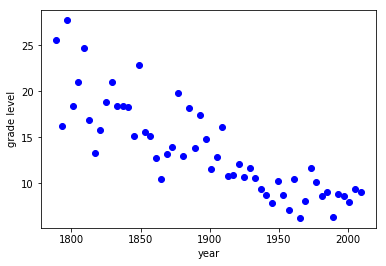

In [10]:
%matplotlib inline

# plot inaugural speech grade-level over time
import matplotlib.pyplot as pyplot

years = []
grade_lvls = []
for name in names:
    filetext = inaugural.raw(fileids=name)
    year = int(name.split('-')[0])
    years.append(year)
    
    doc = nlp(filetext)
    ts = textacy.TextStats(doc)
    grade_lvl = ts.readability_stats['flesch_kincaid_grade_level']
    grade_lvls.append(grade_lvl)

pyplot.plot(years, grade_lvls, 'bo')
pyplot.xlabel('year')
pyplot.ylabel('grade level')

In [26]:
# Use spaCy to generate list of terms from corpus of documents
import os
import textacy
from spacy.lang.en.stop_words import STOP_WORDS

# import the inaugural addresses
from nltk.corpus import inaugural

names = inaugural.fileids()
print(names)

terms_list = []

for name in names:
    filetext = inaugural.raw(fileids=name)
    doc = nlp(filetext)
    terms_list.append([token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS and token.text.isalnum()])


[u'1789-Washington.txt', u'1793-Washington.txt', u'1797-Adams.txt', u'1801-Jefferson.txt', u'1805-Jefferson.txt', u'1809-Madison.txt', u'1813-Madison.txt', u'1817-Monroe.txt', u'1821-Monroe.txt', u'1825-Adams.txt', u'1829-Jackson.txt', u'1833-Jackson.txt', u'1837-VanBuren.txt', u'1841-Harrison.txt', u'1845-Polk.txt', u'1849-Taylor.txt', u'1853-Pierce.txt', u'1857-Buchanan.txt', u'1861-Lincoln.txt', u'1865-Lincoln.txt', u'1869-Grant.txt', u'1873-Grant.txt', u'1877-Hayes.txt', u'1881-Garfield.txt', u'1885-Cleveland.txt', u'1889-Harrison.txt', u'1893-Cleveland.txt', u'1897-McKinley.txt', u'1901-McKinley.txt', u'1905-Roosevelt.txt', u'1909-Taft.txt', u'1913-Wilson.txt', u'1917-Wilson.txt', u'1921-Harding.txt', u'1925-Coolidge.txt', u'1929-Hoover.txt', u'1933-Roosevelt.txt', u'1937-Roosevelt.txt', u'1941-Roosevelt.txt', u'1945-Roosevelt.txt', u'1949-Truman.txt', u'1953-Eisenhower.txt', u'1957-Eisenhower.txt', u'1961-Kennedy.txt', u'1965-Johnson.txt', u'1969-Nixon.txt', u'1973-Nixon.txt', u'

## Topic modeling with spaCy and textacy

Topic models can provide a means to analyze and categorize a corpus of texts. Topics often refer to clusters of words that frequently occur together. 

In [ ]:
# Use spaCy to generate list of terms from corpus of documents
import os
import textacy
from spacy.lang.en.stop_words import STOP_WORDS

# import the inaugural addresses
from nltk.corpus import inaugural

names = inaugural.fileids()
print(names)

# create list of terms from token lemmas in texts
terms_list = []

for name in names:
    filetext = inaugural.raw(fileids=name)
    doc = nlp(filetext)
    terms_list.append([token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS and token.text.isalnum()])


======================model=================
TopicModel(n_topics=20, model=NMF)
('topic', 0, ':', u'government   union   states   texas   revenue   power   constitution   protection   extend   interest')
('topic', 1, ':', u'america   new   let   nation   world   century   today   time   promise   child')
(0, 0.02670888606815352)
(1, 0.09806385019270215)
(2, 0.038580696846285345)
(3, 0.04688088439967463)
(4, 0.041915832910233396)
(5, 0.04128349413025342)
(6, 0.03869926246823957)
(7, 0.03984167814001792)
(8, 0.04178108170691892)
(9, 0.042771260463757885)
(10, 0.05805346495453704)
(11, 0.047667524952166924)
(12, 0.04974217557860261)
(13, 0.05207972677653405)
(14, 0.054501953801617625)
(15, 0.039055342582997137)
(16, 0.056759474881363875)
(17, 0.0593012819775912)
(18, 0.06710291543866406)
(19, 0.059209211729688745)


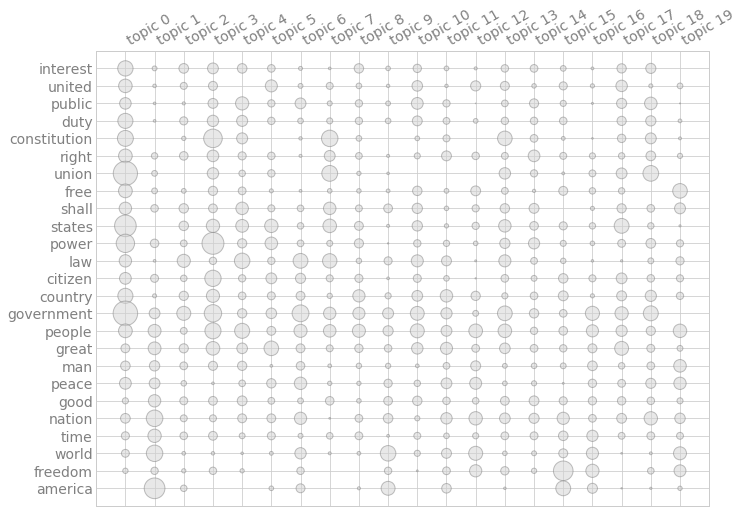

In [11]:
%matplotlib inline
import matplotlib
 
# create word vectors from speech terms
import textacy
from textacy.vsm import Vectorizer

vectorizer = Vectorizer(tf_type='linear', apply_idf=True, idf_type='smooth')
doc_term_matrix = vectorizer.fit_transform(terms_list)

#initialize and train a topic model:
model = textacy.tm.TopicModel('nmf', n_topics=20)
model.fit(doc_term_matrix)

print ("======================model=================")
print (model)
 
doc_topic_matrix = model.transform(doc_term_matrix)
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, topics=[0,1]):
    print('topic', topic_idx, ':', '   '.join(top_terms))
    
for i, val in enumerate(model.topic_weights(doc_topic_matrix)):
     print(i, val)
           
model.termite_plot(doc_term_matrix, vectorizer.id_to_term, topics=-1,  n_terms=25, sort_terms_by='seriation')  
model.save('nmf-25topics_inaugural.pkl')        


## Semantic networks

Represent documents as semantic networks, where nodes are individual terms or whole sentences and edges are weighted by the strength of their co-occurrence or similarity, respectively. This allows the determination of relatedness between either terms or sentences.

In [ ]:
# Semantic networks
import textacy.keyterms

text = 'The quick brown fox jumped over the lazy dog. The cow jumped over the moon. The dish ran away with the spoon.'

doc = textacy.Doc(unicode(text), lang= nlp)
ng = doc.to_semantic_network()
#textacy.viz.network.draw_semantic_network(ng)

## And much much more...
https://spacy.io/usage/linguistic-features